In [1]:
%run ../input/python-recipes/radial_gradient_header.py
%radial_gradient_header Code Modules & Helpful Tools|24

In [2]:
import tensorflow as tf,os,math,numpy as np
from tensorflow.keras import layers as tkl
from tensorflow.keras import callbacks as tkc
from tensorflow.keras.preprocessing.image import \
load_img,array_to_img,img_to_array
from tensorflow.keras.preprocessing import \
image_dataset_from_directory
from IPython.display import display
import pylab as pl,PIL
from mpl_toolkits.axes_grid1.inset_locator import \
zoomed_inset_axes,mark_inset

In [3]:
%radial_gradient_header Data Loading|24

In [4]:
dataset_url='http://www.eecs.berkeley.edu/Research/'+\
            'Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz'
data_dir=tf.keras.utils.get_file(
    origin=dataset_url,fname='BSR',untar=True)
root_dir=os.path.join(data_dir,'BSDS500/data')
data_path=os.path.join(root_dir,'images')
test_path=os.path.join(data_path,'test')
test_paths=sorted(
    [os.path.join(test_path,fname) 
    for fname in os.listdir(test_path)
    if fname.endswith('.jpg')])
test_paths[:3]

70770688/70763455 [==============================] - 20s 0us/step


['/root/.keras/datasets/BSR/BSDS500/data/images/test/100007.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/100039.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/100099.jpg']

In [5]:
%radial_gradient_header Data Processing|24

In [6]:
def scale01(img): return img/255
def process_input(input_rgb,img_size):
    input_yuv=tf.image.rgb_to_yuv(input_rgb)
    last_dimension_axis=len(input_yuv.shape)-1
    y,u,v=tf.split(input_yuv,3,axis=last_dimension_axis)
    return tf.image.resize(y,[img_size,img_size],method='area')
def process_target(input_rgb):
    input_yuv=tf.image.rgb_to_yuv(input_rgb)
    last_dimension_axis=len(input_yuv.shape)-1
    y,u,v=tf.split(input_yuv,3,axis=last_dimension_axis)
    return y

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


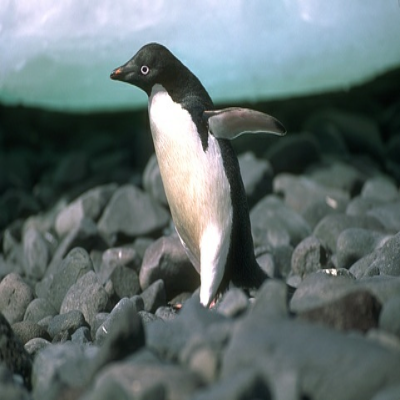

In [7]:
[crop_size,upscale_factor]=[400,4]
input_size=crop_size//upscale_factor
batch_size=8
train_ds=image_dataset_from_directory(
    root_dir,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='training',
    seed=123,label_mode=None,)
valid_ds=image_dataset_from_directory(
    root_dir,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='validation',
    seed=1234,label_mode=None,)
train_ds=train_ds.map(scale01)
valid_ds=valid_ds.map(scale01)
for batch in train_ds.take(1):
    for img in batch: display(array_to_img(img)); break

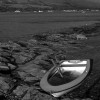

==> ==> ==> ==> ==> ==> ==> ==> ==> ==> 


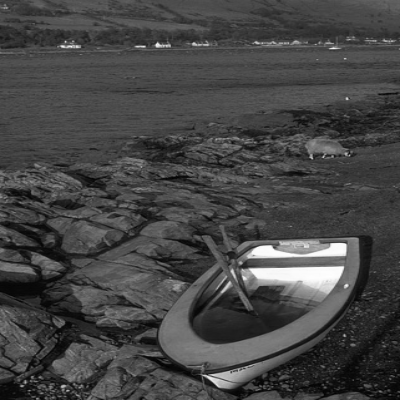

In [8]:
train_ds=train_ds.map(
    lambda x: (process_input(x,input_size),process_target(x)))
train_ds=train_ds.prefetch(buffer_size=16)
valid_ds=valid_ds.map(
    lambda x: (process_input(x,input_size),process_target(x)))
valid_ds=valid_ds.prefetch(buffer_size=16)
for batch in valid_ds.take(1):
    for img in batch[0]: display(array_to_img(img)); break
    print(10*'==> ')
    for img in batch[1]: display(array_to_img(img)); break

In [9]:
%radial_gradient_header Model Building|24

In [10]:
def model(upscale_factor=upscale_factor,channels=1):
    conv_args={'activation':'relu',
               'kernel_initializer':'Orthogonal',
               'padding':'same',}
    inputs=tf.keras.Input(shape=(None,None,channels))
    x=tkl.Conv2D(256,5,**conv_args)(inputs)
    x=tkl.Conv2D(96,5,**conv_args)(x)
    x=tkl.Conv2D(32,3,**conv_args)(x)
    x=tkl.Conv2D(channels*(upscale_factor**2),3,**conv_args)(x)
    outputs=tf.nn.depth_to_space(x,upscale_factor)
    return tf.keras.Model(inputs,outputs)

In [11]:
%radial_gradient_header Visualizations & Callbacks|24

In [12]:
def display_results(img,prefix,title):
    img_array=img_to_array(img)
    img_array=img_array.astype('float32')/255
    fig,ax=pl.subplots()
    im=ax.imshow(img_array[::-1],origin='lower')
    pl.title(title)
    axins=zoomed_inset_axes(ax,2,loc=5)
    axins.imshow(img_array[::-1],origin='lower')
    x1,x2,y1,y2=200,300,100,200
    axins.set_xlim(x1,x2); axins.set_ylim(y1,y2)
    pl.yticks(visible=False); pl.xticks(visible=False)
    mark_inset(ax,axins,loc1=2,loc2=3,fc='none',ec='magenta')
    pl.savefig(str(prefix)+'-'+title+'.png')
    pl.show()
def low_resolution_img(img,upscale_factor):
    dimensions=(img.size[0]//upscale_factor,
                img.size[1]//upscale_factor)
    return img.resize(dimensions,PIL.Image.BICUBIC,)
def upscale_img(model,img):
    ycbcr=img.convert('YCbCr')
    y,cb,cr=ycbcr.split()
    y=img_to_array(y).astype('float32')/255
    input_img=np.expand_dims(y,axis=0)
    out=model.predict(input_img)
    out_img_y=out[0]*255.
    out_img_y=out_img_y.clip(0,255)
    out_img_y=out_img_y.reshape(
        (np.shape(out_img_y)[0],np.shape(out_img_y)[1]))
    out_img_y=PIL.Image.fromarray(np.uint8(out_img_y),mode='L')
    out_img_cb=cb.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img_cr=cr.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img=PIL.Image.merge(
        'YCbCr',(out_img_y,out_img_cb,out_img_cr))
    return out_img.convert('RGB')

In [13]:
class ESPCNCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback,self).__init__()
        self.test_img=low_resolution_img(
            load_img(test_paths[0]),upscale_factor)
    def on_epoch_begin(self,epoch,logs=None):
        self.psnr=[]
    def on_epoch_end(self,epoch,logs=None):
        print('mean PSNR for epoch: %.2f'%(np.mean(self.psnr)))
        if epoch%25==0:
            prediction=upscale_img(self.model,self.test_img)
            display_results(
                prediction,'epoch-'+str(epoch),'prediction')
    def on_test_batch_end(self,batch,logs=None):
        self.psnr.append(10*math.log10(1/logs['loss']))

In [14]:
early_stopping=tkc.EarlyStopping(monitor='loss',patience=10)
checkpoint_path='/tmp/checkpoint'
checkpoint=tkc.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    monitor='loss',mode='min',save_best_only=True,verbose=2)

In [15]:
%radial_gradient_header Model Compiling and Training|24

In [16]:
model=model(upscale_factor=upscale_factor,channels=1)
model.summary()
callbacks=[ESPCNCallback(),early_stopping,checkpoint]
loss_fn=tf.keras.losses.MeanSquaredError()
optimizer=tf.keras.optimizers.Adam(learning_rate=.001)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 256)   6656      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 96)    614496    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    27680     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    4624      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0         
Total params: 653,456
Trainable params: 653,456
Non-trainable params: 0
_______________________________________________________

Epoch 1/200
50/50 - 7s - loss: 0.0316 - val_loss: 0.0063
mean PSNR for epoch: 22.04


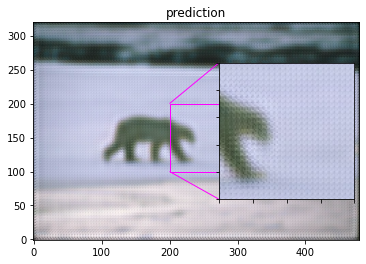


Epoch 00001: loss improved from inf to 0.03157, saving model to /tmp/checkpoint
Epoch 2/200
50/50 - 3s - loss: 0.0054 - val_loss: 0.0040
mean PSNR for epoch: 24.12

Epoch 00002: loss improved from 0.03157 to 0.00544, saving model to /tmp/checkpoint
Epoch 3/200
50/50 - 4s - loss: 0.0039 - val_loss: 0.0034
mean PSNR for epoch: 24.38

Epoch 00003: loss improved from 0.00544 to 0.00394, saving model to /tmp/checkpoint
Epoch 4/200
50/50 - 3s - loss: 0.0032 - val_loss: 0.0028
mean PSNR for epoch: 25.61

Epoch 00004: loss improved from 0.00394 to 0.00324, saving model to /tmp/checkpoint
Epoch 5/200
50/50 - 4s - loss: 0.0030 - val_loss: 0.0028
mean PSNR for epoch: 25.56

Epoch 00005: loss improved from 0.00324 to 0.00301, saving model to /tmp/checkpoint
Epoch 6/200
50/50 - 3s - loss: 0.0029 - val_loss: 0.0026
mean PSNR for epoch: 25.95

Epoch 00006: loss improved from 0.00301 to 0.00289, saving model to /tmp/checkpoint
Epoch 7/200
50/50 - 3s - loss: 0.0028 - val_loss: 0.0026
mean PSNR for epo

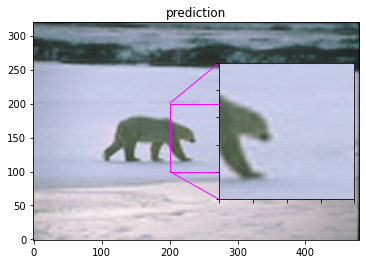


Epoch 00026: loss did not improve from 0.00250
Epoch 27/200
50/50 - 3s - loss: 0.0027 - val_loss: 0.0023
mean PSNR for epoch: 26.77

Epoch 00027: loss did not improve from 0.00250
Epoch 28/200
50/50 - 3s - loss: 0.0025 - val_loss: 0.0023
mean PSNR for epoch: 26.41

Epoch 00028: loss improved from 0.00250 to 0.00249, saving model to /tmp/checkpoint
Epoch 29/200
50/50 - 3s - loss: 0.0025 - val_loss: 0.0023
mean PSNR for epoch: 26.50

Epoch 00029: loss improved from 0.00249 to 0.00248, saving model to /tmp/checkpoint
Epoch 30/200
50/50 - 3s - loss: 0.0025 - val_loss: 0.0023
mean PSNR for epoch: 26.65

Epoch 00030: loss improved from 0.00248 to 0.00247, saving model to /tmp/checkpoint
Epoch 31/200
50/50 - 3s - loss: 0.0025 - val_loss: 0.0023
mean PSNR for epoch: 26.64

Epoch 00031: loss did not improve from 0.00247
Epoch 32/200
50/50 - 4s - loss: 0.0025 - val_loss: 0.0023
mean PSNR for epoch: 26.60

Epoch 00032: loss improved from 0.00247 to 0.00246, saving model to /tmp/checkpoint
Epoch 

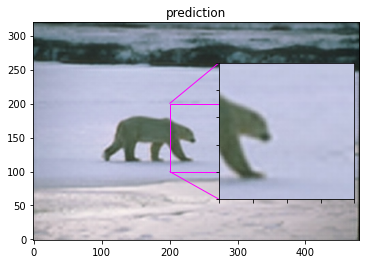


Epoch 00051: loss did not improve from 0.00239
Epoch 52/200
50/50 - 3s - loss: 0.0024 - val_loss: 0.0022
mean PSNR for epoch: 26.44

Epoch 00052: loss did not improve from 0.00239
Epoch 53/200
50/50 - 3s - loss: 0.0024 - val_loss: 0.0022
mean PSNR for epoch: 26.11

Epoch 00053: loss did not improve from 0.00239
Epoch 54/200
50/50 - 3s - loss: 0.0024 - val_loss: 0.0022
mean PSNR for epoch: 26.74

Epoch 00054: loss improved from 0.00239 to 0.00239, saving model to /tmp/checkpoint
Epoch 55/200
50/50 - 3s - loss: 0.0024 - val_loss: 0.0023
mean PSNR for epoch: 26.72

Epoch 00055: loss did not improve from 0.00239
Epoch 56/200
50/50 - 3s - loss: 0.0032 - val_loss: 0.0024
mean PSNR for epoch: 26.55

Epoch 00056: loss did not improve from 0.00239
Epoch 57/200
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
mean PSNR for epoch: 26.22

Epoch 00057: loss did not improve from 0.00239
Epoch 58/200
50/50 - 3s - loss: 0.0024 - val_loss: 0.0022
mean PSNR for epoch: 26.73

Epoch 00058: loss did not impro

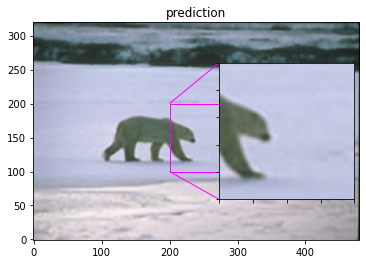


Epoch 00076: loss did not improve from 0.00236
Epoch 77/200
50/50 - 3s - loss: 0.0024 - val_loss: 0.0022
mean PSNR for epoch: 26.69

Epoch 00077: loss did not improve from 0.00236
Epoch 78/200
50/50 - 3s - loss: 0.0024 - val_loss: 0.0022
mean PSNR for epoch: 26.80

Epoch 00078: loss improved from 0.00236 to 0.00235, saving model to /tmp/checkpoint
Epoch 79/200
50/50 - 4s - loss: 0.0023 - val_loss: 0.0022
mean PSNR for epoch: 26.51

Epoch 00079: loss improved from 0.00235 to 0.00235, saving model to /tmp/checkpoint
Epoch 80/200
50/50 - 3s - loss: 0.0024 - val_loss: 0.0022
mean PSNR for epoch: 26.46

Epoch 00080: loss did not improve from 0.00235
Epoch 81/200
50/50 - 4s - loss: 0.0024 - val_loss: 0.0022
mean PSNR for epoch: 26.55

Epoch 00081: loss did not improve from 0.00235
Epoch 82/200
50/50 - 4s - loss: 0.0024 - val_loss: 0.0022
mean PSNR for epoch: 26.56

Epoch 00082: loss did not improve from 0.00235
Epoch 83/200
50/50 - 3s - loss: 0.0024 - val_loss: 0.0022
mean PSNR for epoch: 2

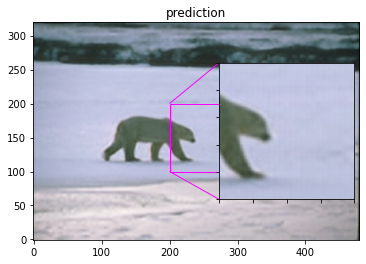


Epoch 00101: loss did not improve from 0.00233
Epoch 102/200
50/50 - 3s - loss: 0.0023 - val_loss: 0.0022
mean PSNR for epoch: 26.72

Epoch 00102: loss improved from 0.00233 to 0.00232, saving model to /tmp/checkpoint
Epoch 103/200
50/50 - 3s - loss: 0.0023 - val_loss: 0.0022
mean PSNR for epoch: 26.64

Epoch 00103: loss did not improve from 0.00232
Epoch 104/200
50/50 - 3s - loss: 0.0023 - val_loss: 0.0022
mean PSNR for epoch: 27.07

Epoch 00104: loss did not improve from 0.00232
Epoch 105/200
50/50 - 3s - loss: 0.0023 - val_loss: 0.0022
mean PSNR for epoch: 26.87

Epoch 00105: loss improved from 0.00232 to 0.00232, saving model to /tmp/checkpoint
Epoch 106/200
50/50 - 3s - loss: 0.0024 - val_loss: 0.0022
mean PSNR for epoch: 26.59

Epoch 00106: loss did not improve from 0.00232
Epoch 107/200
50/50 - 3s - loss: 0.0024 - val_loss: 0.0022
mean PSNR for epoch: 26.42

Epoch 00107: loss did not improve from 0.00232
Epoch 108/200
50/50 - 3s - loss: 0.0023 - val_loss: 0.0022
mean PSNR for e

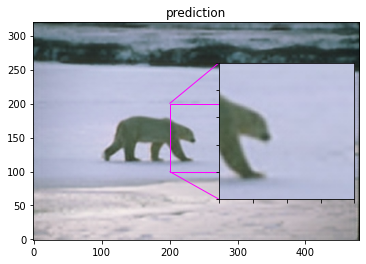


Epoch 00126: loss did not improve from 0.00230
Epoch 127/200
50/50 - 3s - loss: 0.0029 - val_loss: 0.0023
mean PSNR for epoch: 26.62

Epoch 00127: loss did not improve from 0.00230
Epoch 128/200
50/50 - 4s - loss: 0.0024 - val_loss: 0.0022
mean PSNR for epoch: 26.90

Epoch 00128: loss did not improve from 0.00230


In [17]:
epochs=200
model.compile(optimizer=optimizer,loss=loss_fn,)
history=model.fit(
    train_ds,epochs=epochs,callbacks=callbacks,
    validation_data=valid_ds,verbose=2)
model.load_weights(checkpoint_path);

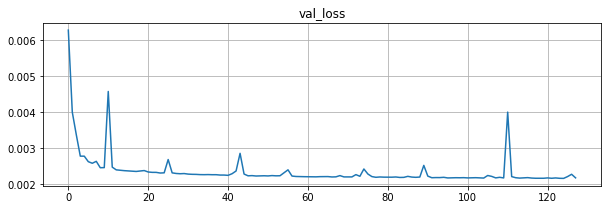

In [18]:
history_keys=list(history.history.keys())
pl.figure(figsize=(10,3))
pl.plot(history.history[history_keys[1]])
pl.grid(); pl.title(history_keys[1]);

In [19]:
%radial_gradient_header Test Results|24

PSNR of low resolution and high resolution is 21.9522
PSNR of predict and high resolution is 22.5880


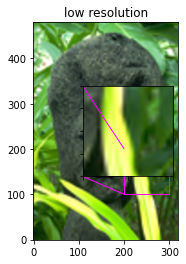

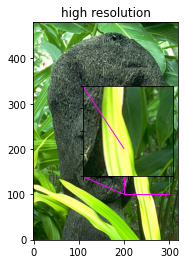

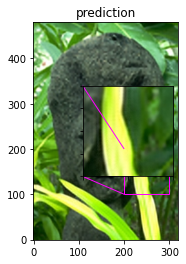

PSNR of low resolution and high resolution is 20.5894
PSNR of predict and high resolution is 20.9574


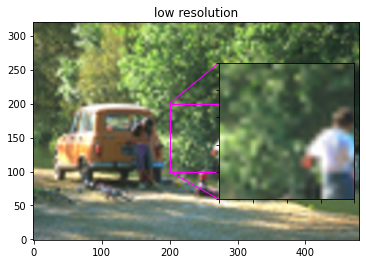

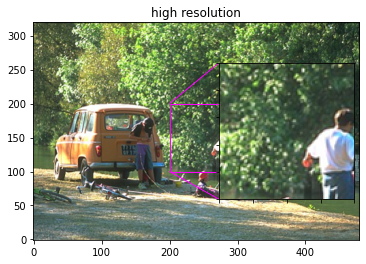

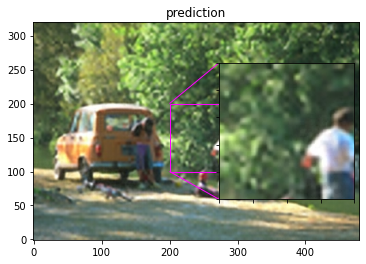

PSNR of low resolution and high resolution is 22.6938
PSNR of predict and high resolution is 23.4075


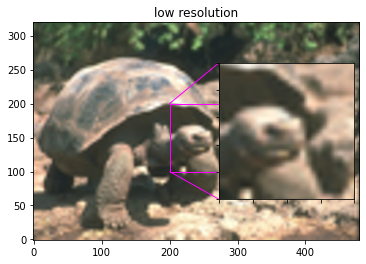

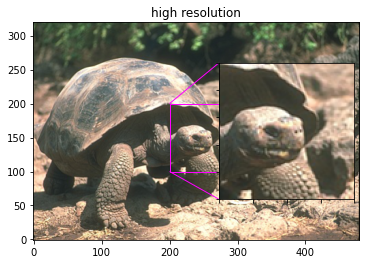

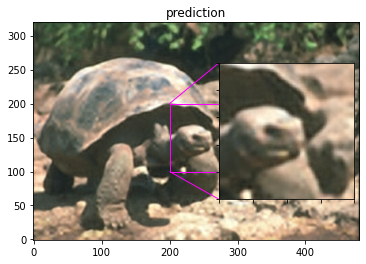

PSNR of low resolution and high resolution is 32.0279
PSNR of predict and high resolution is 32.9952


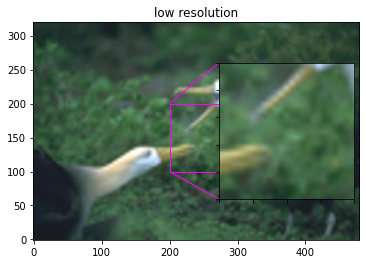

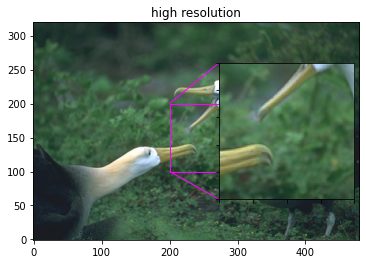

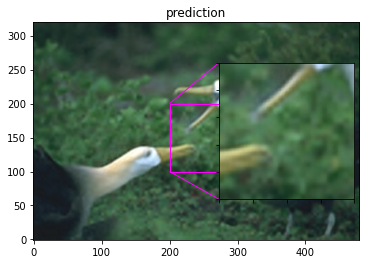

PSNR of low resolution and high resolution is 25.4892
PSNR of predict and high resolution is 26.1550


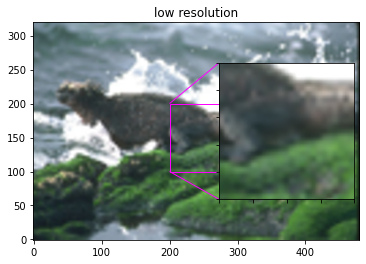

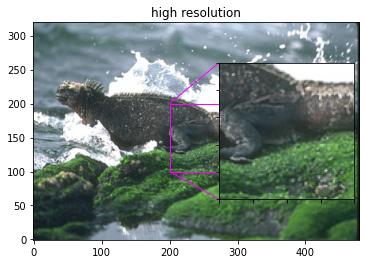

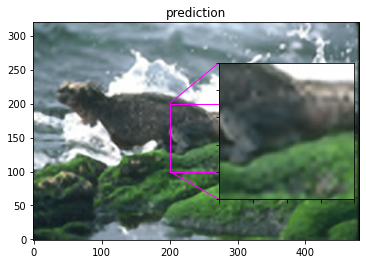

avg. PSNR of images with low resolution is 12.2753
avg. PSNR of reconstructions is 12.6103


In [20]:
total_bicubic_psnr=0.; total_test_psnr=0.
for index,test_path in enumerate(test_paths[5:10]):
    img=load_img(test_path)
    lowres_input=low_resolution_img(img,upscale_factor)
    w=lowres_input.size[0]*upscale_factor
    h=lowres_input.size[1]*upscale_factor
    highres_img=img.resize((w,h))
    predict_img=upscale_img(model,lowres_input)
    lowres_img=lowres_input.resize((w,h))
    lowres_img_arr=img_to_array(lowres_img)
    highres_img_arr=img_to_array(highres_img)
    predict_img_arr=img_to_array(predict_img)
    bicubic_psnr=tf.image.psnr(
        lowres_img_arr,highres_img_arr,max_val=255)
    test_psnr=tf.image.psnr(
        predict_img_arr,highres_img_arr,max_val=255)
    total_bicubic_psnr+=bicubic_psnr
    total_test_psnr+=test_psnr
    print('PSNR of low resolution '+\
          'and high resolution is %.4f'%bicubic_psnr)
    print('PSNR of predict and high resolution is %.4f'%test_psnr)
    display_results(lowres_img,index,'low resolution')
    display_results(highres_img,index,'high resolution')
    display_results(predict_img,index,'prediction')
print('avg. PSNR of images with low resolution is %.4f'\
      %(total_bicubic_psnr/10))
print('avg. PSNR of reconstructions is %.4f'\
      %(total_test_psnr/10))